In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
import torchvision.models as models
import eagerpy as ep
from foolbox import PyTorchModel, accuracy, samples
from foolbox.attacks import PGD, FGSM
import matplotlib.pyplot as plt


from src.models  import CifarResNet, MNIST_CNN, CIFAR_CNN
from src.helpers import evaluate_rob_accuracy, evaluate_clean_accuracy, load_model, safe_model,_evaluate_model
from src.data_loader import load_torchvision_dataset, load_imagenette
#from src.pruning import identify_layers, _evaluate_sparsity

import time

if torch.cuda.is_available() == True:
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
print(device)
dtype = torch.float32

cuda:0


In [12]:
def PGD(model, data_loader, criterion, steps, max_stepsize, eps, device):
    model.eval()
    advs = []
    correct = 0
    total = 0
    for i, data in enumerate(data_loader):
        if i == i:
            inputs, labels = data
            inputs, labels =inputs.to(device), labels.to(device)

            adv_examples = inputs
            adv_examples.requires_grad = True
            adv_examples.retain_grad()
            for step in range(steps):
                #print(torch.max(adv_examples[0]-inputs[0][0]))
                adv_examples, pert = FGSM_step(model, adv_examples, labels, criterion, max_stepsize, device)
                pert = adv_examples - inputs
                pert.clamp_(-eps, eps)
                adv_examples = inputs + pert
                adv_examples.clamp_(0,1)
            advs.append(adv_examples)
            preds = model(adv_examples)
            #pred_labels = 
            _, predicted = torch.max(preds.data, 1)
            total += len(predicted)
            #correct += (pred_labels == labels).sum().item()
            correct += (predicted != labels).sum().item()
    return advs, correct/total
        

def FGSM_step(model, inputs, labels, criterion, eps, device):

    inputs.retain_grad()
    perturbation = torch.zeros_like(inputs).to(device)
    preds = model(inputs)
    loss = criterion(preds, labels)
    loss.backward(retain_graph=True)
    perturbation = torch.sign(inputs.grad).clamp_(-eps, eps)
    adv_examples = inputs + perturbation
    adv_examples.clamp_(0,1)
    return adv_examples, perturbation
    

def FGSM(model, data_loader, criterion, eps, device):
    model.eval()
    #mean, std = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)
    #mean = torch.tensor(mean).view(3,1,1).expand(3,32,32).to(device)
    #std = torch.tensor(std).view(3,1,1).expand(3,32,32).to(device)
    advs = []
    correct = 0
    total = 0
    for i,data in enumerate(data_loader):
        if i < 10:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            inputs.requires_grad = True
            adv_examples, perturbation = FGSM_step(model, inputs, labels, criterion, eps, device)

            advs.append(adv_examples)
            preds = model(adv_examples)
            #pred_labels = 
            _, predicted = torch.max(preds.data, 1)
            total += len(predicted)
            #correct += (pred_labels == labels).sum().item()
            correct += (predicted != labels).sum().item()

    
    return advs, correct/total

In [4]:
def load_torchvision_dataset(dataset, batchsize=512, data_augmentation=False, shuffle=True):
    if data_augmentation == True:
        train_transforms = torchvision.transforms.Compose([
            #torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
            torchvision.transforms.RandomHorizontalFlip(),
            torchvision.transforms.RandomRotation(20),
            torchvision.transforms.Resize(40),
            torchvision.transforms.RandomResizedCrop(32),
            torchvision.transforms.ToTensor(),
            #torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),        
        ])
    if data_augmentation == False:
        train_transforms = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            #torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),        
        ])
    val_transforms = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        #torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])
    
    
    if dataset == 'MNIST':
        train = torchvision.datasets.MNIST('./data', train=True, transform=torchvision.transforms.ToTensor(), download=True)
        test = torchvision.datasets.MNIST('./data', train=False, transform=torchvision.transforms.ToTensor(), download=True)
        attack = torchvision.datasets.MNIST('./data', train=False, transform=torchvision.transforms.ToTensor(), download=True)
    if dataset == 'CIFAR10':
        train = torchvision.datasets.CIFAR10('./data', train=True, transform=train_transforms, download=True)
        test = torchvision.datasets.CIFAR10('./data', train=False, transform=val_transforms, download=True)
        attack = torchvision.datasets.CIFAR10('./data', train=False, transform=torchvision.transforms.ToTensor(), download=True)
    train_loader = torch.utils.data.DataLoader(
        train,
        batch_size=batchsize,
        shuffle=shuffle,
    )
    test_loader = torch.utils.data.DataLoader(
        test,
        batch_size=batchsize,
        shuffle=shuffle,
    )
    attack_loader = torch.utils.data.DataLoader(
        attack,
        batch_size=batchsize,
        shuffle=shuffle,
    )
    return train_loader, test_loader

In [5]:
model = CifarResNet()
model.to(device)
train_loader, test_loader = load_torchvision_dataset('CIFAR10', data_augmentation=True)

identifying layers
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [5]:
train_stats = model.fit_fast(train_loader, test_loader, 100, device)

fast adversarial training
fast adv. train.
[1,     1] loss: 6.24548, adv_train_accuracy: 0.00, clean_train_accuracy : 18.36
[1,    11] loss: 7.48917, adv_train_accuracy: 11.52, clean_train_accuracy : 11.13
[1,    21] loss: 4.45007, adv_train_accuracy: 11.13, clean_train_accuracy : 15.04
[1,    31] loss: 3.13092, adv_train_accuracy: 14.06, clean_train_accuracy : 18.95
[1,    41] loss: 2.87374, adv_train_accuracy: 8.01, clean_train_accuracy : 16.99
[1,    51] loss: 2.75230, adv_train_accuracy: 15.23, clean_train_accuracy : 20.31
[1,    61] loss: 3.35220, adv_train_accuracy: 13.28, clean_train_accuracy : 23.44
[1,    71] loss: 2.42029, adv_train_accuracy: 11.13, clean_train_accuracy : 20.31
[1,    81] loss: 2.41274, adv_train_accuracy: 10.74, clean_train_accuracy : 20.31
[1,    91] loss: 2.36847, adv_train_accuracy: 15.43, clean_train_accuracy : 25.00
0.840625
0.8283203125
duration: 193 s - train loss: 5.10343 - train accuracy: 11.33 - validation loss: 2.09287 - validation accuracy: 28.52

[9,    61] loss: 2.04419, adv_train_accuracy: 24.02, clean_train_accuracy : 35.74
[9,    71] loss: 2.10378, adv_train_accuracy: 20.90, clean_train_accuracy : 29.69
[9,    81] loss: 2.10470, adv_train_accuracy: 19.53, clean_train_accuracy : 28.52
[9,    91] loss: 2.04133, adv_train_accuracy: 21.29, clean_train_accuracy : 32.42
0.779296875
0.7130859375
duration: 193 s - train loss: 2.07987 - train accuracy: 22.29 - validation loss: 1.68458 - validation accuracy: 40.38 
[10,     1] loss: 2.02710, adv_train_accuracy: 25.39, clean_train_accuracy : 33.20
[10,    11] loss: 2.05175, adv_train_accuracy: 21.09, clean_train_accuracy : 33.59
[10,    21] loss: 2.08253, adv_train_accuracy: 23.44, clean_train_accuracy : 35.35
[10,    31] loss: 1.99495, adv_train_accuracy: 25.39, clean_train_accuracy : 38.28
[10,    41] loss: 2.07223, adv_train_accuracy: 20.31, clean_train_accuracy : 32.62
[10,    51] loss: 2.01737, adv_train_accuracy: 24.41, clean_train_accuracy : 37.30
[10,    61] loss: 2.13436, adv

[18,     1] loss: 1.99763, adv_train_accuracy: 25.00, clean_train_accuracy : 38.87
[18,    11] loss: 1.98450, adv_train_accuracy: 25.00, clean_train_accuracy : 36.72
[18,    21] loss: 2.01204, adv_train_accuracy: 22.66, clean_train_accuracy : 36.91
[18,    31] loss: 1.97325, adv_train_accuracy: 27.15, clean_train_accuracy : 42.77
[18,    41] loss: 1.97644, adv_train_accuracy: 25.39, clean_train_accuracy : 40.62
[18,    51] loss: 1.96699, adv_train_accuracy: 27.15, clean_train_accuracy : 40.82
[18,    61] loss: 2.02902, adv_train_accuracy: 22.85, clean_train_accuracy : 37.30
[18,    71] loss: 1.96984, adv_train_accuracy: 26.37, clean_train_accuracy : 38.48
[18,    81] loss: 1.99101, adv_train_accuracy: 26.17, clean_train_accuracy : 38.28
[18,    91] loss: 1.97518, adv_train_accuracy: 27.73, clean_train_accuracy : 40.82
0.770703125
[19,    61] loss: 2.05349, adv_train_accuracy: 20.90, clean_train_accuracy : 32.81
[19,    71] loss: 1.99580, adv_train_accuracy: 26.17, clean_train_accuracy 

[27,    11] loss: 1.99124, adv_train_accuracy: 26.37, clean_train_accuracy : 42.19
[27,    21] loss: 1.98278, adv_train_accuracy: 27.93, clean_train_accuracy : 41.80
[27,    31] loss: 2.00439, adv_train_accuracy: 25.59, clean_train_accuracy : 41.60
[27,    41] loss: 1.97521, adv_train_accuracy: 25.78, clean_train_accuracy : 42.77
[27,    51] loss: 1.90919, adv_train_accuracy: 32.62, clean_train_accuracy : 42.77
[27,    61] loss: 1.93826, adv_train_accuracy: 25.59, clean_train_accuracy : 44.73
[27,    71] loss: 1.94733, adv_train_accuracy: 29.88, clean_train_accuracy : 45.12
[27,    81] loss: 2.01273, adv_train_accuracy: 24.80, clean_train_accuracy : 39.06
[27,    91] loss: 1.95912, adv_train_accuracy: 27.93, clean_train_accuracy : 44.34
0.759375
0.685546875
duration: 190 s - train loss: 1.96762 - train accuracy: 26.21 - validation loss: 1.45326 - validation accuracy: 50.34 
[28,     1] loss: 1.95100, adv_train_accuracy: 27.34, clean_train_accuracy : 47.27
[28,    11] loss: 2.04450, adv

[35,    61] loss: 1.89965, adv_train_accuracy: 31.84, clean_train_accuracy : 48.05
[35,    71] loss: 1.90523, adv_train_accuracy: 31.45, clean_train_accuracy : 46.09
[35,    81] loss: 1.95820, adv_train_accuracy: 27.93, clean_train_accuracy : 42.19
[35,    91] loss: 1.97237, adv_train_accuracy: 27.73, clean_train_accuracy : 47.07
0.740234375
0.65
duration: 185 s - train loss: 1.92473 - train accuracy: 27.97 - validation loss: 1.36718 - validation accuracy: 54.26 
[36,     1] loss: 1.90254, adv_train_accuracy: 28.12, clean_train_accuracy : 45.70
[36,    11] loss: 1.93038, adv_train_accuracy: 28.91, clean_train_accuracy : 45.51
[36,    21] loss: 1.88921, adv_train_accuracy: 30.27, clean_train_accuracy : 46.88
[36,    31] loss: 1.92242, adv_train_accuracy: 28.32, clean_train_accuracy : 47.27
[36,    41] loss: 1.92661, adv_train_accuracy: 27.73, clean_train_accuracy : 44.92
[36,    51] loss: 1.88766, adv_train_accuracy: 29.49, clean_train_accuracy : 49.61
[36,    61] loss: 1.92109, adv_tra

[44,     1] loss: 1.82907, adv_train_accuracy: 29.10, clean_train_accuracy : 49.80
[44,    11] loss: 1.97150, adv_train_accuracy: 23.44, clean_train_accuracy : 42.58
[44,    21] loss: 1.89894, adv_train_accuracy: 26.76, clean_train_accuracy : 45.51
[44,    31] loss: 1.88083, adv_train_accuracy: 27.73, clean_train_accuracy : 50.59
[44,    41] loss: 1.94586, adv_train_accuracy: 27.15, clean_train_accuracy : 44.14
[44,    51] loss: 1.89015, adv_train_accuracy: 31.05, clean_train_accuracy : 46.48
[44,    61] loss: 1.89348, adv_train_accuracy: 30.66, clean_train_accuracy : 51.37
[44,    71] loss: 1.91750, adv_train_accuracy: 25.20, clean_train_accuracy : 45.90
[44,    81] loss: 1.86729, adv_train_accuracy: 29.49, clean_train_accuracy : 45.51
[44,    91] loss: 1.86972, adv_train_accuracy: 29.30, clean_train_accuracy : 48.83
0.7193359375
0.6560546875
duration: 192 s - train loss: 1.88369 - train accuracy: 29.11 - validation loss: 1.31582 - validation accuracy: 54.58 
[45,     1] loss: 1.90236

[52,    51] loss: 1.84816, adv_train_accuracy: 30.08, clean_train_accuracy : 50.98
[52,    61] loss: 1.86620, adv_train_accuracy: 28.91, clean_train_accuracy : 50.39
[52,    71] loss: 1.87298, adv_train_accuracy: 29.30, clean_train_accuracy : 46.88
[52,    81] loss: 1.81303, adv_train_accuracy: 29.88, clean_train_accuracy : 52.34
[52,    91] loss: 1.83687, adv_train_accuracy: 31.64, clean_train_accuracy : 50.98
0.7154296875
0.640625
duration: 184 s - train loss: 1.84891 - train accuracy: 30.58 - validation loss: 1.21642 - validation accuracy: 58.12 
[53,     1] loss: 1.81512, adv_train_accuracy: 28.71, clean_train_accuracy : 51.56
[53,    11] loss: 1.84262, adv_train_accuracy: 32.81, clean_train_accuracy : 51.17
[53,    21] loss: 1.78755, adv_train_accuracy: 27.93, clean_train_accuracy : 52.93
[53,    31] loss: 1.90739, adv_train_accuracy: 27.54, clean_train_accuracy : 48.63
[53,    41] loss: 1.93176, adv_train_accuracy: 23.44, clean_train_accuracy : 45.12
[53,    51] loss: 1.89989, ad

0.6931640625
0.6283203125
duration: 185 s - train loss: 1.82080 - train accuracy: 31.54 - validation loss: 1.17518 - validation accuracy: 60.01 
[61,     1] loss: 1.82978, adv_train_accuracy: 31.25, clean_train_accuracy : 54.88
[61,    11] loss: 1.80540, adv_train_accuracy: 30.66, clean_train_accuracy : 56.25
[61,    21] loss: 1.87973, adv_train_accuracy: 28.71, clean_train_accuracy : 47.66
[61,    31] loss: 1.82334, adv_train_accuracy: 30.47, clean_train_accuracy : 49.41
[61,    41] loss: 1.76350, adv_train_accuracy: 32.42, clean_train_accuracy : 55.27
[61,    51] loss: 1.78447, adv_train_accuracy: 35.35, clean_train_accuracy : 53.12
[61,    61] loss: 1.85297, adv_train_accuracy: 32.62, clean_train_accuracy : 50.00
[61,    71] loss: 1.83581, adv_train_accuracy: 28.71, clean_train_accuracy : 50.78
[61,    81] loss: 1.83810, adv_train_accuracy: 30.86, clean_train_accuracy : 51.76
[61,    91] loss: 1.82796, adv_train_accuracy: 31.64, clean_train_accuracy : 52.93
0.7060546875
0.6279296875

[69,    41] loss: 1.78701, adv_train_accuracy: 33.98, clean_train_accuracy : 54.10
[69,    51] loss: 1.79058, adv_train_accuracy: 33.40, clean_train_accuracy : 55.66
[69,    61] loss: 1.83678, adv_train_accuracy: 31.84, clean_train_accuracy : 51.95
[69,    71] loss: 1.79002, adv_train_accuracy: 34.77, clean_train_accuracy : 55.47
[69,    81] loss: 1.79453, adv_train_accuracy: 34.77, clean_train_accuracy : 51.17
[69,    91] loss: 1.76140, adv_train_accuracy: 32.62, clean_train_accuracy : 51.17
0.6982421875
0.6232421875
duration: 184 s - train loss: 1.79347 - train accuracy: 32.76 - validation loss: 1.10884 - validation accuracy: 61.98 
[70,     1] loss: 1.80111, adv_train_accuracy: 31.84, clean_train_accuracy : 50.98
[70,    11] loss: 1.81565, adv_train_accuracy: 33.98, clean_train_accuracy : 54.30
[70,    21] loss: 1.78711, adv_train_accuracy: 34.18, clean_train_accuracy : 56.84
[70,    31] loss: 1.66340, adv_train_accuracy: 41.02, clean_train_accuracy : 57.42
[70,    41] loss: 1.75433

[77,    91] loss: 1.77787, adv_train_accuracy: 31.64, clean_train_accuracy : 54.10
0.6841796875
0.6279296875
duration: 184 s - train loss: 1.76894 - train accuracy: 33.65 - validation loss: 1.10633 - validation accuracy: 61.68 
[78,     1] loss: 1.69862, adv_train_accuracy: 37.50, clean_train_accuracy : 59.57
[78,    11] loss: 1.78136, adv_train_accuracy: 37.50, clean_train_accuracy : 58.20
[78,    21] loss: 1.79831, adv_train_accuracy: 32.81, clean_train_accuracy : 53.71
[78,    31] loss: 1.79534, adv_train_accuracy: 33.79, clean_train_accuracy : 55.66
[78,    41] loss: 1.79677, adv_train_accuracy: 31.84, clean_train_accuracy : 56.45
[78,    51] loss: 1.76870, adv_train_accuracy: 32.62, clean_train_accuracy : 56.45
[78,    61] loss: 1.74416, adv_train_accuracy: 34.96, clean_train_accuracy : 54.10
[78,    71] loss: 1.77910, adv_train_accuracy: 30.86, clean_train_accuracy : 56.64
[78,    81] loss: 1.74571, adv_train_accuracy: 33.98, clean_train_accuracy : 56.45
[78,    91] loss: 1.71968

[87,     1] loss: 1.74436, adv_train_accuracy: 33.40, clean_train_accuracy : 56.45
[87,    11] loss: 1.67182, adv_train_accuracy: 34.57, clean_train_accuracy : 57.42
[87,    21] loss: 1.75348, adv_train_accuracy: 33.59, clean_train_accuracy : 53.12
[87,    31] loss: 1.71774, adv_train_accuracy: 33.98, clean_train_accuracy : 56.84
[87,    41] loss: 1.76977, adv_train_accuracy: 33.20, clean_train_accuracy : 53.71
[87,    51] loss: 1.74625, adv_train_accuracy: 33.59, clean_train_accuracy : 57.81
[87,    61] loss: 1.75290, adv_train_accuracy: 33.20, clean_train_accuracy : 58.01
[87,    71] loss: 1.69286, adv_train_accuracy: 33.59, clean_train_accuracy : 59.38
[87,    81] loss: 1.72620, adv_train_accuracy: 36.52, clean_train_accuracy : 55.86
[87,    91] loss: 1.76641, adv_train_accuracy: 35.55, clean_train_accuracy : 60.74
0.6794921875
0.5998046875
duration: 184 s - train loss: 1.73128 - train accuracy: 34.65 - validation loss: 1.03395 - validation accuracy: 64.66 
[88,     1] loss: 1.78416

[95,    51] loss: 1.81883, adv_train_accuracy: 31.05, clean_train_accuracy : 56.05
[95,    61] loss: 1.71291, adv_train_accuracy: 33.79, clean_train_accuracy : 59.96
[95,    71] loss: 1.70654, adv_train_accuracy: 36.33, clean_train_accuracy : 61.13
[95,    81] loss: 1.70474, adv_train_accuracy: 36.72, clean_train_accuracy : 62.30
[95,    91] loss: 1.75650, adv_train_accuracy: 33.01, clean_train_accuracy : 56.45
0.669140625
0.5927734375
duration: 192 s - train loss: 1.71313 - train accuracy: 35.50 - validation loss: 0.99052 - validation accuracy: 66.91 
[96,     1] loss: 1.66758, adv_train_accuracy: 36.33, clean_train_accuracy : 60.55
[96,    11] loss: 1.71879, adv_train_accuracy: 39.26, clean_train_accuracy : 59.96
[96,    21] loss: 1.68289, adv_train_accuracy: 37.89, clean_train_accuracy : 61.33
[96,    31] loss: 1.71984, adv_train_accuracy: 36.13, clean_train_accuracy : 58.59
[96,    41] loss: 1.67395, adv_train_accuracy: 38.09, clean_train_accuracy : 59.77
[96,    51] loss: 1.72533,

In [6]:
PATH = './saved-models/cifar-resnet-fast-100-epochs.pth'
torch.save({
        'epoch': 100,
        'model_state_dict': model.state_dict(),
        }, PATH)

In [7]:
train_stats1 = model.fit_fast(train_loader, test_loader, 100, device)

fast adversarial training
fast adv. train.
[1,     1] loss: 1.66856, adv_train_accuracy: 37.70, clean_train_accuracy : 64.26
[1,    11] loss: 1.75248, adv_train_accuracy: 33.01, clean_train_accuracy : 56.64
[1,    21] loss: 1.73944, adv_train_accuracy: 33.59, clean_train_accuracy : 53.52
[1,    31] loss: 1.72856, adv_train_accuracy: 35.35, clean_train_accuracy : 60.16
[1,    41] loss: 1.64640, adv_train_accuracy: 36.91, clean_train_accuracy : 59.57
[1,    51] loss: 1.70116, adv_train_accuracy: 36.72, clean_train_accuracy : 58.20
[1,    61] loss: 1.73351, adv_train_accuracy: 32.42, clean_train_accuracy : 58.59
[1,    71] loss: 1.76894, adv_train_accuracy: 33.59, clean_train_accuracy : 55.27
[1,    81] loss: 1.74671, adv_train_accuracy: 32.42, clean_train_accuracy : 59.38
[1,    91] loss: 1.74011, adv_train_accuracy: 33.01, clean_train_accuracy : 54.88
0.64765625
0.583984375
duration: 188 s - train loss: 1.70493 - train accuracy: 35.64 - validation loss: 0.99675 - validation accuracy: 65

[9,    61] loss: 1.63051, adv_train_accuracy: 40.23, clean_train_accuracy : 58.98
[9,    71] loss: 1.70527, adv_train_accuracy: 37.11, clean_train_accuracy : 59.77
[9,    81] loss: 1.69267, adv_train_accuracy: 37.70, clean_train_accuracy : 62.89
[9,    91] loss: 1.69663, adv_train_accuracy: 36.72, clean_train_accuracy : 59.18
0.658203125
0.58046875
duration: 184 s - train loss: 1.66953 - train accuracy: 37.26 - validation loss: 0.95854 - validation accuracy: 66.44 
[10,     1] loss: 1.65323, adv_train_accuracy: 38.09, clean_train_accuracy : 55.27
[10,    11] loss: 1.62083, adv_train_accuracy: 37.50, clean_train_accuracy : 59.57
[10,    21] loss: 1.70966, adv_train_accuracy: 34.77, clean_train_accuracy : 57.42
[10,    31] loss: 1.63102, adv_train_accuracy: 40.62, clean_train_accuracy : 64.26
[10,    41] loss: 1.71669, adv_train_accuracy: 35.16, clean_train_accuracy : 57.03
[10,    51] loss: 1.73153, adv_train_accuracy: 34.57, clean_train_accuracy : 60.55
[10,    61] loss: 1.62225, adv_t

[18,     1] loss: 0.70508, adv_train_accuracy: 75.59, clean_train_accuracy : 62.50
[18,    11] loss: 0.59213, adv_train_accuracy: 81.05, clean_train_accuracy : 58.59
[18,    21] loss: 0.50417, adv_train_accuracy: 83.59, clean_train_accuracy : 56.25
[18,    31] loss: 0.44692, adv_train_accuracy: 84.77, clean_train_accuracy : 59.57
[18,    41] loss: 0.48281, adv_train_accuracy: 83.01, clean_train_accuracy : 52.93
[18,    51] loss: 0.62277, adv_train_accuracy: 79.88, clean_train_accuracy : 60.74
[18,    61] loss: 0.64278, adv_train_accuracy: 77.15, clean_train_accuracy : 53.12
[18,    71] loss: 0.57398, adv_train_accuracy: 81.45, clean_train_accuracy : 62.70
[18,    81] loss: 0.69824, adv_train_accuracy: 75.98, clean_train_accuracy : 57.62
[18,    91] loss: 0.55563, adv_train_accuracy: 83.20, clean_train_accuracy : 64.06
0.8431640625
0.6947265625
duration: 193 s - train loss: 0.59679 - train accuracy: 80.29 - validation loss: 0.85993 - validation accuracy: 72.81 
[19,     1] loss: 0.66234

[26,    51] loss: 0.27810, adv_train_accuracy: 90.23, clean_train_accuracy : 61.91
[26,    61] loss: 0.41897, adv_train_accuracy: 86.33, clean_train_accuracy : 56.45
[26,    71] loss: 0.39834, adv_train_accuracy: 88.09, clean_train_accuracy : 65.82
[26,    81] loss: 0.36925, adv_train_accuracy: 87.30, clean_train_accuracy : 63.28
[26,    91] loss: 0.28689, adv_train_accuracy: 90.04, clean_train_accuracy : 59.57
0.4453125
0.324609375
duration: 185 s - train loss: 0.29665 - train accuracy: 90.15 - validation loss: 1.03212 - validation accuracy: 73.76 
[27,     1] loss: 0.28371, adv_train_accuracy: 90.62, clean_train_accuracy : 63.67
[27,    11] loss: 0.30424, adv_train_accuracy: 89.45, clean_train_accuracy : 54.69
[27,    21] loss: 0.29896, adv_train_accuracy: 90.04, clean_train_accuracy : 61.33
[27,    31] loss: 0.34701, adv_train_accuracy: 89.84, clean_train_accuracy : 60.55
[27,    41] loss: 0.22363, adv_train_accuracy: 92.77, clean_train_accuracy : 60.74
[27,    51] loss: 0.20607, ad

0.22421875
0.2140625
duration: 185 s - train loss: 0.22045 - train accuracy: 92.77 - validation loss: 0.94493 - validation accuracy: 77.29 
[35,     1] loss: 0.16332, adv_train_accuracy: 95.90, clean_train_accuracy : 61.52
[35,    11] loss: 0.21065, adv_train_accuracy: 93.16, clean_train_accuracy : 65.23
[35,    21] loss: 0.21400, adv_train_accuracy: 93.16, clean_train_accuracy : 60.74
[35,    31] loss: 0.22202, adv_train_accuracy: 92.58, clean_train_accuracy : 62.50
[35,    41] loss: 0.21658, adv_train_accuracy: 92.58, clean_train_accuracy : 64.26
[35,    51] loss: 0.24467, adv_train_accuracy: 91.60, clean_train_accuracy : 58.01
[35,    61] loss: 0.20539, adv_train_accuracy: 94.34, clean_train_accuracy : 63.09
[35,    71] loss: 0.24316, adv_train_accuracy: 91.60, clean_train_accuracy : 60.74
[35,    81] loss: 0.18523, adv_train_accuracy: 93.36, clean_train_accuracy : 66.99
[35,    91] loss: 0.16102, adv_train_accuracy: 94.53, clean_train_accuracy : 61.72
0.1236328125
0.1564453125
dura

[43,    41] loss: 0.18786, adv_train_accuracy: 93.95, clean_train_accuracy : 65.23
[43,    51] loss: 0.16205, adv_train_accuracy: 94.34, clean_train_accuracy : 61.91
[43,    61] loss: 0.18791, adv_train_accuracy: 95.31, clean_train_accuracy : 66.02
[43,    71] loss: 0.16490, adv_train_accuracy: 93.75, clean_train_accuracy : 68.55
[43,    81] loss: 0.16782, adv_train_accuracy: 93.75, clean_train_accuracy : 68.55
[43,    91] loss: 0.21781, adv_train_accuracy: 92.58, clean_train_accuracy : 63.09
0.09296875
0.1083984375
duration: 184 s - train loss: 0.19575 - train accuracy: 93.59 - validation loss: 0.97134 - validation accuracy: 75.88 
[44,     1] loss: 0.16657, adv_train_accuracy: 95.12, clean_train_accuracy : 65.43
[44,    11] loss: 0.24143, adv_train_accuracy: 93.16, clean_train_accuracy : 64.45
[44,    21] loss: 0.19009, adv_train_accuracy: 93.16, clean_train_accuracy : 63.67
[44,    31] loss: 0.19168, adv_train_accuracy: 93.55, clean_train_accuracy : 62.89
[44,    41] loss: 0.12497, 

[51,    91] loss: 0.12257, adv_train_accuracy: 95.31, clean_train_accuracy : 67.38
0.037890625
0.083984375
duration: 185 s - train loss: 0.15676 - train accuracy: 94.89 - validation loss: 1.22410 - validation accuracy: 75.44 
[52,     1] loss: 0.15283, adv_train_accuracy: 94.92, clean_train_accuracy : 64.45
[52,    11] loss: 0.18559, adv_train_accuracy: 94.53, clean_train_accuracy : 64.84
[52,    21] loss: 0.17312, adv_train_accuracy: 94.34, clean_train_accuracy : 65.62
[52,    31] loss: 0.13718, adv_train_accuracy: 94.92, clean_train_accuracy : 67.77
[52,    41] loss: 0.20693, adv_train_accuracy: 93.16, clean_train_accuracy : 62.89
[52,    51] loss: 0.14939, adv_train_accuracy: 95.51, clean_train_accuracy : 64.65
[52,    61] loss: 0.24600, adv_train_accuracy: 92.58, clean_train_accuracy : 69.73
[52,    71] loss: 0.23514, adv_train_accuracy: 94.34, clean_train_accuracy : 64.84
[52,    81] loss: 0.15772, adv_train_accuracy: 94.34, clean_train_accuracy : 64.06
[52,    91] loss: 0.17291, 

[60,    31] loss: 0.15598, adv_train_accuracy: 93.95, clean_train_accuracy : 63.28
[60,    41] loss: 0.16389, adv_train_accuracy: 94.34, clean_train_accuracy : 65.82
[60,    51] loss: 0.12185, adv_train_accuracy: 96.88, clean_train_accuracy : 66.99
[60,    61] loss: 0.13018, adv_train_accuracy: 95.51, clean_train_accuracy : 65.43
[60,    71] loss: 0.17068, adv_train_accuracy: 93.75, clean_train_accuracy : 66.99
[60,    81] loss: 0.15011, adv_train_accuracy: 93.36, clean_train_accuracy : 67.97
[60,    91] loss: 0.17547, adv_train_accuracy: 95.51, clean_train_accuracy : 67.38
0.0314453125
0.1017578125
duration: 192 s - train loss: 0.14656 - train accuracy: 95.18 - validation loss: 1.01090 - validation accuracy: 77.72 
[61,     1] loss: 0.12340, adv_train_accuracy: 95.70, clean_train_accuracy : 69.53
[61,    11] loss: 0.17675, adv_train_accuracy: 93.16, clean_train_accuracy : 66.02
[61,    21] loss: 0.15222, adv_train_accuracy: 95.12, clean_train_accuracy : 70.70
[61,    31] loss: 0.12767

[68,    81] loss: 0.15281, adv_train_accuracy: 94.34, clean_train_accuracy : 65.23
[68,    91] loss: 0.17229, adv_train_accuracy: 94.92, clean_train_accuracy : 70.12
0.0333984375
0.119140625
duration: 192 s - train loss: 0.16150 - train accuracy: 94.67 - validation loss: 1.13768 - validation accuracy: 77.21 
[69,     1] loss: 0.21420, adv_train_accuracy: 94.14, clean_train_accuracy : 66.02
[69,    11] loss: 0.13169, adv_train_accuracy: 94.92, clean_train_accuracy : 69.53
[69,    21] loss: 0.23536, adv_train_accuracy: 92.77, clean_train_accuracy : 67.77
[69,    31] loss: 0.15819, adv_train_accuracy: 94.53, clean_train_accuracy : 66.41
[69,    41] loss: 0.18316, adv_train_accuracy: 94.34, clean_train_accuracy : 63.48
[69,    51] loss: 0.16375, adv_train_accuracy: 95.51, clean_train_accuracy : 67.97
[69,    61] loss: 0.19051, adv_train_accuracy: 93.16, clean_train_accuracy : 63.67
[69,    71] loss: 0.16217, adv_train_accuracy: 93.55, clean_train_accuracy : 68.55
[69,    81] loss: 0.21232,

[77,    21] loss: 0.12347, adv_train_accuracy: 95.90, clean_train_accuracy : 68.55
[77,    31] loss: 0.17013, adv_train_accuracy: 95.31, clean_train_accuracy : 67.19
[77,    41] loss: 0.14210, adv_train_accuracy: 94.73, clean_train_accuracy : 62.11
[77,    51] loss: 0.13495, adv_train_accuracy: 94.92, clean_train_accuracy : 65.62
[77,    61] loss: 0.13966, adv_train_accuracy: 94.73, clean_train_accuracy : 67.38
[77,    71] loss: 0.19890, adv_train_accuracy: 93.75, clean_train_accuracy : 65.62
[77,    81] loss: 0.08717, adv_train_accuracy: 97.27, clean_train_accuracy : 68.75
[77,    91] loss: 0.11449, adv_train_accuracy: 96.48, clean_train_accuracy : 66.99
0.0189453125
0.064453125
duration: 192 s - train loss: 0.14366 - train accuracy: 95.30 - validation loss: 1.02123 - validation accuracy: 78.42 
[78,     1] loss: 0.18957, adv_train_accuracy: 94.53, clean_train_accuracy : 68.16
[78,    11] loss: 0.10030, adv_train_accuracy: 96.88, clean_train_accuracy : 66.02
[78,    21] loss: 0.13036,

[85,    71] loss: 0.16134, adv_train_accuracy: 93.36, clean_train_accuracy : 68.75
[85,    81] loss: 0.12724, adv_train_accuracy: 95.31, clean_train_accuracy : 68.16
[85,    91] loss: 0.11326, adv_train_accuracy: 96.68, clean_train_accuracy : 66.60
0.0205078125
0.057421875
duration: 192 s - train loss: 0.13304 - train accuracy: 95.61 - validation loss: 1.16432 - validation accuracy: 78.52 
[86,     1] loss: 0.08425, adv_train_accuracy: 97.85, clean_train_accuracy : 67.19
[86,    11] loss: 0.07268, adv_train_accuracy: 97.27, clean_train_accuracy : 72.27
[86,    21] loss: 0.09589, adv_train_accuracy: 97.07, clean_train_accuracy : 66.41
[86,    31] loss: 0.11353, adv_train_accuracy: 96.09, clean_train_accuracy : 68.36
[86,    41] loss: 0.10039, adv_train_accuracy: 97.07, clean_train_accuracy : 70.51
[86,    51] loss: 0.08708, adv_train_accuracy: 97.07, clean_train_accuracy : 70.31
[86,    61] loss: 0.09067, adv_train_accuracy: 97.07, clean_train_accuracy : 72.27
[86,    71] loss: 0.08544,

[94,    11] loss: 0.07365, adv_train_accuracy: 97.85, clean_train_accuracy : 68.75
[94,    21] loss: 0.14953, adv_train_accuracy: 95.31, clean_train_accuracy : 68.75
[94,    31] loss: 0.15975, adv_train_accuracy: 94.14, clean_train_accuracy : 66.21
[94,    41] loss: 0.14811, adv_train_accuracy: 95.12, clean_train_accuracy : 64.06
[94,    51] loss: 0.14137, adv_train_accuracy: 95.31, clean_train_accuracy : 70.51
[94,    61] loss: 0.12818, adv_train_accuracy: 95.12, clean_train_accuracy : 67.58
[94,    71] loss: 0.11358, adv_train_accuracy: 96.68, clean_train_accuracy : 63.28
[94,    81] loss: 0.15220, adv_train_accuracy: 95.90, clean_train_accuracy : 64.84
[94,    91] loss: 0.09331, adv_train_accuracy: 96.48, clean_train_accuracy : 71.88
0.02890625
0.08125
duration: 192 s - train loss: 0.15171 - train accuracy: 95.06 - validation loss: 1.03223 - validation accuracy: 79.69 
[95,     1] loss: 0.16078, adv_train_accuracy: 95.90, clean_train_accuracy : 69.92
[95,    11] loss: 0.11356, adv_t

In [8]:
PATH = './saved-models/cifar-resnet-fast-200-epochs.pth'
torch.save({
        'epoch': 200,
        'model_state_dict': model.state_dict(),
        }, PATH)

In [9]:
train_stats2 = model.fit_fast(train_loader, test_loader, 100, device)

fast adversarial training
fast adv. train.
[1,     1] loss: 0.16923, adv_train_accuracy: 93.55, clean_train_accuracy : 65.62
[1,    11] loss: 0.12603, adv_train_accuracy: 95.51, clean_train_accuracy : 66.99
[1,    21] loss: 0.12352, adv_train_accuracy: 95.12, clean_train_accuracy : 68.55
[1,    31] loss: 0.12536, adv_train_accuracy: 95.70, clean_train_accuracy : 71.88
[1,    41] loss: 0.10198, adv_train_accuracy: 96.09, clean_train_accuracy : 66.21
[1,    51] loss: 0.11760, adv_train_accuracy: 96.29, clean_train_accuracy : 67.19
[1,    61] loss: 0.08857, adv_train_accuracy: 97.46, clean_train_accuracy : 68.55
[1,    71] loss: 0.12697, adv_train_accuracy: 95.51, clean_train_accuracy : 69.73
[1,    81] loss: 0.05962, adv_train_accuracy: 97.85, clean_train_accuracy : 68.95
[1,    91] loss: 0.15804, adv_train_accuracy: 94.34, clean_train_accuracy : 67.38
0.0341796875
0.1130859375
duration: 193 s - train loss: 0.12273 - train accuracy: 95.97 - validation loss: 1.08391 - validation accuracy:

[9,    61] loss: 0.06920, adv_train_accuracy: 98.05, clean_train_accuracy : 70.70
[9,    71] loss: 0.12082, adv_train_accuracy: 96.48, clean_train_accuracy : 68.75
[9,    81] loss: 0.13744, adv_train_accuracy: 95.51, clean_train_accuracy : 69.92
[9,    91] loss: 0.09700, adv_train_accuracy: 96.29, clean_train_accuracy : 71.48
0.024609375
0.0580078125
duration: 192 s - train loss: 0.11087 - train accuracy: 96.46 - validation loss: 1.01707 - validation accuracy: 80.10 
[10,     1] loss: 0.08070, adv_train_accuracy: 96.48, clean_train_accuracy : 65.62
[10,    11] loss: 0.16325, adv_train_accuracy: 94.34, clean_train_accuracy : 67.97
[10,    21] loss: 0.08608, adv_train_accuracy: 96.88, clean_train_accuracy : 68.16
[10,    31] loss: 0.18510, adv_train_accuracy: 93.55, clean_train_accuracy : 64.26
[10,    41] loss: 0.09882, adv_train_accuracy: 96.88, clean_train_accuracy : 67.97
[10,    51] loss: 0.09764, adv_train_accuracy: 96.68, clean_train_accuracy : 67.58
[10,    61] loss: 0.10136, adv

[18,     1] loss: 0.09879, adv_train_accuracy: 96.88, clean_train_accuracy : 70.70
[18,    11] loss: 0.11271, adv_train_accuracy: 97.27, clean_train_accuracy : 70.90
[18,    21] loss: 0.12798, adv_train_accuracy: 96.48, clean_train_accuracy : 68.16
[18,    31] loss: 0.15513, adv_train_accuracy: 95.31, clean_train_accuracy : 71.09
[18,    41] loss: 0.11850, adv_train_accuracy: 96.09, clean_train_accuracy : 69.53
[18,    51] loss: 0.09113, adv_train_accuracy: 97.07, clean_train_accuracy : 70.51
[18,    61] loss: 0.15887, adv_train_accuracy: 95.51, clean_train_accuracy : 71.88
[18,    71] loss: 0.08790, adv_train_accuracy: 96.88, clean_train_accuracy : 68.75
[18,    81] loss: 0.10243, adv_train_accuracy: 96.48, clean_train_accuracy : 66.02
[18,    91] loss: 0.13359, adv_train_accuracy: 94.34, clean_train_accuracy : 68.55
0.0361328125
0.090625
duration: 192 s - train loss: 0.11104 - train accuracy: 96.43 - validation loss: 1.06316 - validation accuracy: 78.79 
[19,     1] loss: 0.06642, ad

[26,    51] loss: 0.07994, adv_train_accuracy: 97.27, clean_train_accuracy : 66.41
[26,    61] loss: 0.05914, adv_train_accuracy: 97.46, clean_train_accuracy : 72.07
[26,    71] loss: 0.16224, adv_train_accuracy: 94.53, clean_train_accuracy : 64.65
[26,    81] loss: 0.14334, adv_train_accuracy: 95.70, clean_train_accuracy : 71.09
[26,    91] loss: 0.10099, adv_train_accuracy: 96.29, clean_train_accuracy : 67.97
0.2146484375
0.18359375
duration: 192 s - train loss: 0.11743 - train accuracy: 96.17 - validation loss: 1.01117 - validation accuracy: 79.25 
[27,     1] loss: 0.06742, adv_train_accuracy: 97.85, clean_train_accuracy : 68.75
[27,    11] loss: 0.11630, adv_train_accuracy: 96.48, clean_train_accuracy : 69.14
[27,    21] loss: 0.12577, adv_train_accuracy: 96.48, clean_train_accuracy : 71.68
[27,    31] loss: 0.14362, adv_train_accuracy: 94.53, clean_train_accuracy : 65.62
[27,    41] loss: 0.15481, adv_train_accuracy: 95.12, clean_train_accuracy : 67.77
[27,    51] loss: 0.18916, 

KeyboardInterrupt: 

In [ ]:
PATH = './saved-models/cifar-resnet-fast-300-epochs.pth'
torch.save({
        'epoch': 300,
        'model_state_dict': model.state_dict(),
        }, PATH)

In [ ]:
train_stats3 = model.fit_fast(train_loader, test_loader, 100, device)

In [ ]:
PATH = './saved-models/cifar-resnet-fast-400-epochs.pth'
torch.save({
        'epoch': 400,
        'model_state_dict': model.state_dict(),
        }, PATH)

In [ ]:
train_stats4 = model.fit_fast(train_loader, test_loader, 100, device)

In [ ]:
PATH = './saved-models/cifar-resnet-fast-500-epochs.pth'
torch.save({
        'epoch': 500,
        'model_state_dict': model.state_dict(),
        }, PATH)

In [ ]:
train_stats5 = model.fit_fast(train_loader, test_loader, 100, device)

In [ ]:
PATH = './saved-models/cifar-resnet-fast-600-epochs.pth'
torch.save({
        'epoch': 600,
        'model_state_dict': model.state_dict(),
        }, PATH)

In [ ]:
train_stats3 = model.fit_fast(train_loader, test_loader, 100, device)

In [ ]:
PATH = './saved-models/cifar-resnet-fast-700-epochs.pth'
torch.save({
        'epoch': 700,
        'model_state_dict': model.state_dict(),
        }, PATH)

In [14]:
checkpoint = torch.load('./saved-models/cifar-resnet-fast-100-epochs.pth')
checkpoint

{'epoch': 100,
 'model_state_dict': OrderedDict([('c1.weights',
               tensor([[[[ 5.2705e-02, -3.1870e-02,  1.8360e-02],
                         [ 3.0918e-01, -3.1207e-01, -5.9072e-02],
                         [ 6.1119e-02, -6.2451e-02,  1.5322e-02]],
               
                        [[-5.4788e-03, -2.2965e-03,  8.3076e-03],
                         [ 5.2809e-02, -4.9895e-02, -1.3867e-03],
                         [ 8.3724e-04, -5.3421e-03,  1.0070e-02]],
               
                        [[-9.4907e-03, -3.1119e-03,  1.9843e-02],
                         [ 1.9212e-01, -1.8495e-01, -1.4722e-02],
                         [ 6.4316e-03, -3.2145e-02,  1.8856e-02]]],
               
               
                       [[[ 3.6953e-03,  7.5328e-02,  5.5013e-02],
                         [-1.2339e-01, -2.9748e-01, -1.9194e-01],
                         [-9.5028e-02, -2.1170e-01, -1.7418e-01]],
               
                        [[-3.1035e-03,  2.0645e-02,  4.3436

In [15]:
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [126]:
evaluate_clean_accuracy(model,test_loader, device)

(59.06, 0.0)

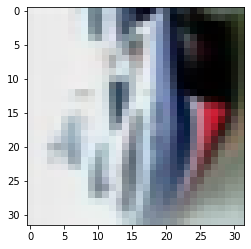

In [50]:
x = next(iter(test_loader))[0][1]
plt.imshow(x.T)

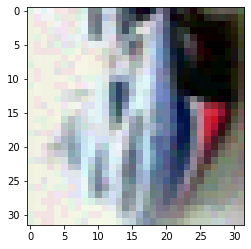

In [63]:
f = f_adv[0][1].cpu().detach()
plt.imshow(f.T)

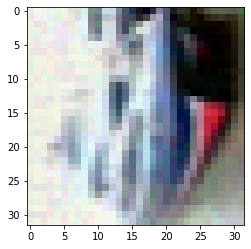

In [112]:
p = p_adv[0][1].cpu().detach()
plt.imshow(p.T)

In [113]:
torch.max(x - f)

tensor(0.0314)

In [114]:
torch.min(x - p)

tensor(-0.0314)

In [103]:
7*2/255

0.054901960784313725

In [16]:
f_adv, success = FGSM(model, test_loader, torch.nn.CrossEntropyLoss(), 8/255, device)
success

0.5669921875

In [17]:
p_adv, success = PGD(model, test_loader, torch.nn.CrossEntropyLoss(), 7, 2/255, 8/255, device)
success

0.6051

In [137]:
fmodel = PyTorchModel(model, bounds=(0, 1))
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)


In [138]:
clean_acc = accuracy(fmodel, images, labels)
print(f"clean accuracy:  {clean_acc * 100:.1f} %")

clean accuracy:  59.2 %


In [140]:
attack = FGSM()
epsilon = 8/255
raw_advs, clipped_advs, success = attack(fmodel, images, labels, epsilons=epsilon)

In [142]:
robust_accuracy = 1 - success.float().mean(axis=-1)

In [143]:
robust_accuracy

tensor(0.0254, device='cuda:0')

In [ ]:
train_stats = model.fit_fast(train_loader, test_loader, 10, device, patience=10)

In [ ]:
_, success = FGSM(model, test_loader, torch.nn.CrossEntropyLoss(), 8/255, device)
success

In [ ]:
_, success = PGD(model, test_loader, torch.nn.CrossEntropyLoss(), 7, 2/255, 8/255, device)
success

In [ ]:
train_stats = model.fit_fast(train_loader, test_loader, 10, device, patience=10)

In [ ]:
_, success = FGSM(model, test_loader, torch.nn.CrossEntropyLoss(), 8/255, device)
success

In [ ]:
_, success = PGD(model, test_loader, torch.nn.CrossEntropyLoss(), 7, 2/255, 8/255, device)
success

In [ ]:
train_stats = model.fit_fast(train_loader, test_loader, 10, device, patience=10)

In [ ]:
_, success = FGSM(model, test_loader, torch.nn.CrossEntropyLoss(), 8/255, device)
success

In [ ]:
_, success = PGD(model, test_loader, torch.nn.CrossEntropyLoss(), 7, 2/255, 8/255, device)
success

In [ ]:
train_stats = model.fit_fast(train_loader, test_loader, 10, device, patience=10)

In [ ]:
_, success = FGSM(model, test_loader, torch.nn.CrossEntropyLoss(), 8/255, device)
success

In [ ]:
_, success = PGD(model, test_loader, torch.nn.CrossEntropyLoss(), 7, 2/255, 8/255, device)
success

In [33]:

import torch.nn.functional as F
from torch import clamp

criterion = torch.nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters())

alpha=10

cifar10_mean = (0.4914, 0.4822, 0.4465)
cifar10_std = (0.2471, 0.2435, 0.2616)

mu = torch.tensor(cifar10_mean).view(3,1,1).cuda()
std = torch.tensor(cifar10_std).view(3,1,1).cuda()

upper_limit = ((1 - mu)/ std)
lower_limit = ((0 - mu)/ std)

def loc_train(model, epochs, epsilon):
    for epoch in range(epochs):
        start_epoch_time = time.time()
        train_loss = 0
        train_acc = 0
        train_n = 0
        for i, (X, y) in enumerate(train_loader):
            X, y = X.cuda(), y.cuda()
            if i == 0:
                first_batch = (X, y)
            delta = torch.zeros_like(X).cuda()
            

            delta.uniform_(-epsilon, epsilon)
            delta.data = clamp(delta, 0,1)
            
            delta.requires_grad = True
            output = model(X + delta[:X.size(0)])
            loss = F.cross_entropy(output, y)
            loss.backward()
            grad = delta.grad.detach()
            delta.data = clamp(delta + alpha * torch.sign(grad), -epsilon, epsilon)
            delta.data[:X.size(0)] = clamp(delta[:X.size(0)], 0,1)
            delta = delta.detach()
            output = model(X + delta[:X.size(0)])
            loss = criterion(output, y)
            opt.zero_grad()
            loss.backward()
            opt.step()
            train_loss += loss.item() * y.size(0)
            train_acc += (output.max(1)[1] == y).sum().item()
            train_n += y.size(0)
            print(train_acc/train_n, train_loss/train_n)
        epoch_time = time.time()
    return model


In [34]:
model = loc_train(model, 10, 8/255)

0.083984375 3.052335500717163
0.0859375 10.463098406791687
0.09309895833333333 10.319573640823364
0.10009765625 9.919875800609589
0.11015625 9.819345045089722
0.11490885416666667 9.664365728696188
0.11830357142857142 9.370375326701573
0.114501953125 9.100074023008347
0.1174045138888889 8.764120499293009
0.11796875 8.358004641532897
0.11807528409090909 7.941281968897039
0.11979166666666667 7.593418478965759
0.12139423076923077 7.339407150561993
0.12346540178571429 7.0954293182918
0.11953125 6.85154751141866
0.1195068359375 6.611902013421059
0.12017463235294118 6.442012885037591
0.12044270833333333 6.290201465288798
0.12099095394736842 6.13347780077081
0.12197265625 5.97891389131546
0.12276785714285714 5.830017419088454
0.12446732954545454 5.711510625752536
0.12567934782608695 5.58311012516851
0.12744140625 5.465107391277949
0.1290625 5.361762580871582
0.12935697115384615 5.25775801218473
0.12962962962962962 5.153595844904582
0.13120814732142858 5.058839687279293
0.1328125 4.972027252460

In [35]:
evaluate_clean_accuracy(model, test_loader, device)

(40.02, 0.0)

In [36]:
_, success = FGSM(model, test_loader, torch.nn.CrossEntropyLoss(), 8/255, device)
success

0.7691

In [37]:
_, success = PGD(model, test_loader, torch.nn.CrossEntropyLoss(), 7, 2/255, 8/255, device)
success

0.9

In [104]:
model, data_loader, criterion, steps, max_stepsize, eps, device = model, test_loader, torch.nn.CrossEntropyLoss(), 7, 2/255, 8/255, device

model.eval()
advs = []
correct = 0
total = 0
for i, data in enumerate(data_loader):
    print(i)
    if i==0:
        inputs, labels = data
        inputs, labels =inputs.to(device), labels.to(device)
        adv_examples = inputs
        #adv_inputs = inputs
        adv_examples.requires_grad = True
        #perturbation = torch.zeros_like(adv_inputs, requires_grad=True).to(device)
        for step in range(steps):

            perturbation = torch.zeros_like(inputs, requires_grad=True).to(device)
            preds = model(adv_examples)
            loss = criterion(preds, labels)
            adv_examples.retain_grad()
            loss.backward()

            perturbation = torch.sign(adv_examples.grad).clamp_(-eps, eps)
            print(inputs)
            adv_examples = adv_examples + perturbation
            #adv_examples, pert = FGSM_step(model, adv_examples, labels, criterion, max_stepsize, device)
            adv_examples.clamp_(-eps, eps)

        advs.append(adv_examples)




0
tensor([[[[0.7490, 0.7490, 0.7529,  ..., 0.6667, 0.6667, 0.6706],
          [0.7569, 0.7608, 0.7686,  ..., 0.6706, 0.6667, 0.6706],
          [0.7725, 0.7725, 0.7725,  ..., 0.6824, 0.6784, 0.6824],
          ...,
          [0.5961, 0.6039, 0.6039,  ..., 0.3412, 0.3529, 0.3882],
          [0.5490, 0.5569, 0.5451,  ..., 0.3843, 0.3451, 0.3098],
          [0.5451, 0.5490, 0.5529,  ..., 0.6000, 0.5961, 0.5725]],

         [[0.8588, 0.8588, 0.8588,  ..., 0.7882, 0.7882, 0.7922],
          [0.8627, 0.8667, 0.8706,  ..., 0.7882, 0.7843, 0.7882],
          [0.8667, 0.8667, 0.8667,  ..., 0.7882, 0.7882, 0.7882],
          ...,
          [0.5725, 0.5765, 0.5765,  ..., 0.3373, 0.3569, 0.3961],
          [0.5294, 0.5333, 0.5294,  ..., 0.3765, 0.3333, 0.3098],
          [0.5255, 0.5333, 0.5373,  ..., 0.5686, 0.5608, 0.5451]],

         [[0.9490, 0.9529, 0.9569,  ..., 0.9020, 0.8980, 0.9020],
          [0.9490, 0.9529, 0.9608,  ..., 0.9020, 0.8941, 0.8980],
          [0.9569, 0.9529, 0.9529,  ...,

RuntimeError: Trying to backward through the graph a second time, but the saved intermediate results have already been freed. Specify retain_graph=True when calling backward the first time.